# TimeEval result analysis on the benchmark datasets (retry run 1)

In [1]:
# imports
import re
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "benchmark-data" / "data-processed"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-11-16_runtime-benchmark-retry1"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-11-01_runtime-gutentag-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-11-16_runtime-benchmark-retry1'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/backup'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6'),
 PosixPath('/home/projects/akita/resu


Selecting:
Data path: /home/projects/akita/data/benchmark-data/data-processed
Result path: /home/projects/akita/results/2021-11-16_runtime-benchmark-retry1


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# add RANGE_PR_AUC if it is not part of the results
if "RANGE_PR_AUC" not in df.columns:
    df["RANGE_PR_AUC"] = np.nan

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-11-16_runtime-benchmark-retry1


Define utility functions

In [4]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [5]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_id, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # deconstruct dataset ID
    collection_name, dataset_name = dataset_id

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[(df["collection"] == collection_name) & (df["dataset"] == dataset_name), "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["collection"] == collection_name) & (df["dataset"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, dataset_id).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_id}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=df_dataset.columns[i]), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_id}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=df_dataset.columns[i])
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_id}")
    fig.tight_layout()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", fmt_label=lambda x: x, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} algorithms)"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title="Algorithms"
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        #ax.boxplot(values, sym="", vert=True, meanline=True, showmeans=True, showfliers=False, manage_ticks=True)
        ax.boxplot(values, vert=True, meanline=True, showmeans=True, showfliers=True, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        ax.legend()
        return fig

## Analyze overall results on the GutenTAG datasets

### Overview

In [6]:
df[["algorithm", "collection", "dataset", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,collection,dataset,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,CBLOF,Exathlon,5_1_100000_63-64,Status.OK,0.622689,0.209238,0.209073,NaN,95.253151,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
1,CBLOF,Exathlon,5_1_100000_64-63,Status.OK,0.884776,0.485645,0.485403,NaN,92.362750,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
2,CBLOF,Exathlon,1_2_100000_68-16,Status.ERROR,NaN,NaN,NaN,NaN,NaN,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
3,CBLOF,Exathlon,4_1_100000_61-29,Status.OK,0.633781,0.359252,0.359204,NaN,204.126040,"{""n_clusters"": 50, ""n_jobs"": 1, ""random_state""..."
4,COF,Exathlon,5_1_100000_63-64,Status.ERROR,NaN,NaN,NaN,NaN,NaN,"{""n_neighbors"": 50, ""random_state"": 42}"
...,...,...,...,...,...,...,...,...,...,...
1914,normal,WebscopeS5,A4Benchmark-86,Status.OK,0.500000,0.009524,0.504762,NaN,0.000026,{}
1915,normal,Exathlon,5_1_100000_63-64,Status.OK,0.500000,0.126248,0.563124,NaN,0.000039,{}
1916,normal,Exathlon,5_1_100000_64-63,Status.OK,0.500000,0.062752,0.531376,NaN,0.000051,{}
1917,normal,Exathlon,1_2_100000_68-16,Status.OK,0.500000,0.788147,0.894074,NaN,0.000034,{}


### Algorithm problems grouped by algorithm training type

In [7]:
index_columns = ["algo_training_type", "algo_input_dimensionality", "algorithm"]
df_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_error_counts = df_error_counts.fillna(value=0).astype(np.int64)
df_error_counts = df_error_counts.reset_index().sort_values(by=["algo_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_error_counts["ALL"] = df_error_counts["Status.ERROR"] + df_error_counts["Status.OK"] + df_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_error_counts.loc[tpe], index=True))
        else:
            display(df_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                              Status.ERROR  Status.OK  \
algo_input_dimensionality algorithm                                           
UNIVARIATE                TARZAN                               9         46   
                          OceanWNN                             1          3   
                          SR-CNN                               1         15   
MULTIVARIATE              TAnoGan                              3         12   
                          Hybrid KNN                           2        109   
                          LSTM-AD                              2          0   
                          DeepAnT                              1          1   
                          EncDec-AD                            1          0   
                          LaserDBN                             1          0   
                          OmniAnomaly                          1          4   
                          Random Black Forest (RR)             1          8   
                          Telemanom                            1         41   
                          HealthESN                            0          0   
                          RobustPCA                            0         12   

status                                              Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                      
UNIVARIATE                TARZAN                                 0   55  
                          OceanWNN                               0    4  
                          SR-CNN                                 9   25  
MULTIVARIATE              TAnoGan                               13   28  
                          Hybrid KNN                             0  111  
                          LSTM-AD                                0    2  
                          DeepAnT                                0    2  
                          EncDec-AD                              1    2  
                          LaserDBN                               1    2  
                          OmniAnomaly                            0    5  
                          Random Black Forest (RR)               2   11  
                          Telemanom                              0   42  
                          HealthESN                              2    2  
                          RobustPCA                              0   12

SUPERVISED


status                                                   Status.ERROR  \
algo_input_dimensionality algorithm                                     
MULTIVARIATE              MultiHMM                                  2   
                          Normalizing Flows                         2   
                          Hybrid Isolation Forest (HIF)             0   

status                                                   Status.OK  \
algo_input_dimensionality algorithm                                  
MULTIVARIATE              MultiHMM                               0   
                          Normalizing Flows                      0   
                          Hybrid Isolation Forest (HIF)          2   

status                                                   Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                           
MULTIVARIATE              MultiHMM                                    0    2  
                          Normalizing Flows                           0    2  
                          Hybrid Isolation Forest (HIF)               0    2

UNSUPERVISED


status                                                     Status.ERROR  \
algo_input_dimensionality algorithm                                       
UNIVARIATE                S-H-ESD (Twitter)                         114   
                          VALMOD                                     26   
                          Triple ES (Holt-Winter's)                  17   
                          Left STAMPi                                14   
                          SAND                                        4   
                          PST                                         3   
                          GrammarViz                                  0   
                          NormA                                       0   
                          NumentaHTM                                  0   
                          PCI                                         0   
                          PhaseSpace-SVM                              0   
                          SSA                                         0   
                          STAMP                                       0   
                          STOMP                                       0   
                          Series2Graph                                0   
                          Spectral Residual (SR)                      0   
                          Subsequence IF                              0   
                          Subsequence LOF                             0   
                          TSBitmap                                    0   
MULTIVARIATE              COF                                         4   
                          DBStream                                    4   
                          Torsk                                       3   
                          k-Means                                     3   
                          PCC                                         2   
                          normal                                      2   
                          CBLOF                                       1   
                          COPOD                                       1   
                          HBOS                                        1   
                          Isolation Forest (iForest)                  1   
                          KNN                                         1   
                          LOF                                         1   
                          Extended Isolation Forest (EIF)             0   
                          IF-LOF                                      0   

status                                                     Status.OK  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                S-H-ESD (Twitter)                       26   
                          VALMOD                                  68   
                          Triple ES (Holt-Winter's)               56   
                          Left STAMPi                             54   
                          SAND                                     8   
                          PST                                     21   
                          GrammarViz                              70   
                          NormA                                    0   
                          NumentaHTM                               4   
                          PCI                                      9   
                          PhaseSpace-SVM                          13   
                          SSA                                     22   
                          STAMP                                   99   
                          STOMP                                  101   
                          Series2Graph                            14   
                          Spectral Residual (SR)                  26   
                          Subsequence IF                          51   
      

### Summary

In [8]:
df_error_summary = pd.DataFrame(df_error_counts.sum(axis=0))
df_error_summary.columns = ["count"]
all_count = df_error_summary.loc["ALL", "count"]
df_error_summary["percentage"] = df_error_summary / all_count
df_error_summary.style.format({"percentage": "{:06.2%}".format})

,count,percentage
status,,
Status.ERROR,230,11.99%
Status.OK,1595,83.12%
Status.TIMEOUT,94,04.90%
ALL,1919,100.00%


Inspect errors of a specific algorithm:

In [12]:
ok = "- OK -"
oom = "- OOM -"
timeout = "- TIMEOUT -"
error_mapping = {
    "TimeoutError": timeout,
    "status code '137'": oom,
    "MemoryError: Unable to allocate": oom,
    "ValueError: Expected 2D array, got 1D array instead": "Wrong shape error",
    "could not broadcast input array from shape": "Wrong shape error",
    "not aligned": "Wrong shape error",  # shapes (20,) and (19,500) not aligned
    "array must not contain infs or NaNs": "unexpected Inf or NaN",
    "contains NaN": "unexpected Inf or NaN",
    "cannot convert float NaN to integer": "unexpected Inf or NaN",
    "Error(s) in loading state_dict": "Model loading error",
    "EOFError": "Model loading error",
    "Restoring from checkpoint failed": "Model loading error",
    "RecursionError: maximum recursion depth exceeded in comparison": "Max recursion depth exceeded",
    "but PCA is expecting": "BROKEN Exathlon DATASETS",  # ValueError: X has 44 features, but PCA is expecting 43 features as input.
    "input.size(-1) must be equal to input_size": "BROKEN Exathlon DATASETS",
    "ValueError: The condensed distance matrix must contain only finite values.": "LinAlgError",
    "LinAlgError": "LinAlgError",
    "NameError: name 'nan' is not defined": "Not converged",
    "Could not form valid cluster separation": "Not converged",
    "contamination must be in": "Invariance/assumption not met",
    "Data must not be constant": "Invariance/assumption not met",
    "Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data": "Invariance/assumption not met",
    "ValueError: Anom detection needs at least 2 periods worth of data": "Invariance/assumption not met",
    "`dataset` input should have multiple elements": "Invariance/assumption not met",
    "Cannot take a larger sample than population": "Invariance/assumption not met",
    "num_samples should be a positive integer value": "Invariance/assumption not met",
    "Cannot use heuristic method to compute initial seasonal and levels with less than periods + 10 datapoints": "Invariance/assumption not met",
    "ValueError: The window size must be less than or equal to 0": "Invariance/assumption not met",
    "The window size must be less than or equal to": "Incompatible parameters",
    "window_size has to be greater": "Incompatible parameters",
    "Set a higher piecewise_median_period_weeks": "Incompatible parameters",
    "OutOfBoundsDatetime: cannot convert input with unit 'm'": "Incompatible parameters",
    "`window_size` must be at least 4": "Incompatible parameters",
    "elements of 'k' must be between": "Incompatible parameters",
    "Expected n_neighbors <= n_samples": "Incompatible parameters",
    "PAA size can't be greater than the timeseries size": "Incompatible parameters",
    "All window sizes must be greater than or equal to": "Incompatible parameters",
    "ValueError: __len__() should return >= 0": "Bug",
    "stack expects a non-empty TensorList": "Bug",
    "expected non-empty vector": "Bug",
    "Found array with 0 feature(s)": "Bug",
    "ValueError: On entry to DLASCL parameter number 4 had an illegal value": "Bug",
    "Sample larger than population or is negative": "Bug",
    "ZeroDivisionError": "Bug",
    "IndexError": "Bug",
    "status code '139'": "Bug",
    "replacement has length zero": "Bug",
    "missing value where TRUE/FALSE needed": "Bug",
    "invalid subscript type 'list'": "Bug",
    "subscript out of bounds": "Bug",
    "invalid argument to unary operator": "Bug",
    "negative length vectors are not allowed": "Bug",
    "negative dimensions are not allowed": "Bug",
    "`std` must be positive": "Bug",
    "does not have key": "Bug",  # State '1' does not have key '1'
    "Less than 2 uniques breaks left": "Bug",
    "The encoder for value is invalid": "Bug",
    "arange: cannot compute length": "Bug",
    "n_components=3 must be between 0 and min(n_samples, n_features)": "Bug",
}

def get_folder(index):
    series = df.loc[index]
    path = (
        result_path /
        series["algorithm"] /
        series["hyper_params_id"] /
        series["collection"] /
        series["dataset"] /
        str(series["repetition"])
    )
    return path
    
def category_from_logfile(logfile):
    with logfile.open() as fh:
        log = fh.read()
    for error in error_mapping:
        if error in log:
            return error_mapping[error]
    #print(log)
    return "other"
    
def extract_category(series):
    status = series["status"]
    msg = series["error_message"]
    if status == "Status.OK":
        return ok
    elif status == "Status.TIMEOUT":
        return timeout
    # status is ERROR:
    elif "DockerAlgorithmFailedError" in msg:
        path = get_folder(series.name) / "execution.log"
        if path.exists():
            return category_from_logfile(path)
        return "DockerAlgorithmFailedError"
    else:
        m = re.search("^([\w]+)\(.*\)", msg)
        if m:
            error = m.group(1)
        else:
            error = msg
        return f"TimeEval:{error}"

df["error_category"] = df.apply(extract_category, axis="columns", raw=False)
df_error_category_overview = df.pivot_table(index="error_category", columns="algorithm", values="repetition", aggfunc="count")
df_error_category_overview.insert(0, "ALL (sum)", df_error_category_overview.sum(axis=1))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_error_category_overview.style.format("{:.0f}", na_rep=""))

algorithm,ALL (sum),CBLOF,COF,COPOD,DBStream,DeepAnT,EncDec-AD,Extended Isolation Forest (EIF),GrammarViz,HBOS,HealthESN,Hybrid Isolation Forest (HIF),Hybrid KNN,IF-LOF,Isolation Forest (iForest),KNN,LOF,LSTM-AD,LaserDBN,Left STAMPi,MultiHMM,NormA,Normalizing Flows,NumentaHTM,OceanWNN,OmniAnomaly,PCC,PCI,PST,PhaseSpace-SVM,Random Black Forest (RR),RobustPCA,S-H-ESD (Twitter),SAND,SR-CNN,SSA,STAMP,STOMP,Series2Graph,Spectral Residual (SR),Subsequence IF,Subsequence LOF,TARZAN,TAnoGan,TSBitmap,Telemanom,Torsk,Triple ES (Holt-Winter's),VALMOD,k-Means,normal
error_category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
- OK -,1595,3,,3,,1,,4,70,3,,2,109,4,3,3,4,,,54,,,,4,3,4,17,9,21,13,8,12,26,8,15,22,99,101,14,26,51,45,46,12,136,41,64,56,68,1,410
- OOM -,43,,3,,3,1,,,,,,,1,,,,,2,1,,,,2,,,1,,,3,,1,,,,,,,,,,,,,2,,1,1,,18,3,
- TIMEOUT -,94,,,,,,1,,,,2,,,,,,,,1,2,,1,,,,,,,,1,2,,,2,9,,6,2,,,,1,,13,,,24,27,,,
Bug,19,,,,,,1,,,,,,1,,,,,,,,,,,,1,,,,,,,,,3,,,,,,,,,4,,,,1,,8,,
Incompatible parameters,118,,,,,,,,,,,,,,,,,,,4,,,,,,,,,,,,,114,,,,,,,,,,,,,,,,,,
Invariance/assumption not met,37,1,1,1,,,,,,1,,,,,1,1,1,,,10,,,,,,,1,,,,,,,,1,,,,,,,,,1,,,,17,,,
Max recursion depth exceeded,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,
Not converged,2,,,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TimeEval:KilledWorker,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1


- SAND Wrong shape error --> no anomaly in dataset (anomaly_window_size=0)
- S-H-ESD (Twitter) incompatible parameter errors --> Cannot parse datetime index (would require further analysis
- Left STAMPi incompatible parameter errors --> anomaly_window_size > n_init_train --> fixed, but **needs re-execution**
- normal baseline TimeEval:KilledWorker --> is likely the source of these errors (on LTDB dataset) --> **try with Docker baseline**
- TimeEval:ValueError --> all on genesis dataset: had an error in labeling --> fixed, but **needs re-execution**
- Invariance/assumption not met errors:
  - Dataset Exathlon 1_2_100000_68-16 has too many anomalies (contamination > 0.5)
  - Left STAMPi has anomaly_window_size > n_init_train; those datasets cannot be processed by this algo
  - TripleES has error `Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data` --> no idea on how to fix; just bad datasets for this method?

In [13]:
df[
    (df["error_category"] == "Incompatible parameters") &
    (df["algorithm"] == "Left STAMPi")
]

,algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,...,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,AVERAGE_PRECISION,overall_time,RANGE_PR_AUC,error_category
252,Left STAMPi,IOPS,adb2fde9-8589-3f5b-a410-5fe14386c7af,UNSUPERVISED,UNIVARIATE,SUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 411, ""n_init_train"": 2...",c7154041299f401511423f541d29014c,NaN,NaN,NaN,0.0,NaN,Incompatible parameters
253,Left STAMPi,NAB,TravelTime_451,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 217, ""n_init_train"": 2...",c7154041299f401511423f541d29014c,NaN,NaN,NaN,0.0,NaN,Incompatible parameters
260,Left STAMPi,NAB,exchange-2_cpc_results,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 163, ""n_init_train"": 1...",c7154041299f401511423f541d29014c,NaN,NaN,NaN,0.0,NaN,Incompatible parameters
261,Left STAMPi,NAB,occupancy_6005,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,DockerAlgorithmFailedError('Please consider lo...,1,"{""anomaly_window_size"": 239, ""n_init_train"": 2...",c7154041299f401511423f541d29014c,NaN,NaN,NaN,0.0,NaN,Incompatible parameters


In [14]:
df[
    #(df["error_category"] == "TimeEval:KilledWorker") &
    (df["algorithm"] == "VALMOD")
][["algorithm", "collection", "dataset", "status", "error_message", "error_category"]]

,algorithm,collection,dataset,status,error_message,error_category
1413,VALMOD,KDD-TSAD,002_UCR_Anomaly_DISTORTED2sddb40,Status.ERROR,DockerAlgorithmFailedError('Please consider lo...,- OOM -
1414,VALMOD,KDD-TSAD,003_UCR_Anomaly_DISTORTED3sddb40,Status.ERROR,DockerAlgorithmFailedError('Please consider lo...,- OOM -
1415,VALMOD,KDD-TSAD,004_UCR_Anomaly_DISTORTEDBIDMC1,Status.OK,NaN,- OK -
1416,VALMOD,KDD-TSAD,015_UCR_Anomaly_DISTORTEDECG4,Status.ERROR,DockerAlgorithmFailedError('Please consider lo...,- OOM -
1417,VALMOD,KDD-TSAD,017_UCR_Anomaly_DISTORTEDECG4,Status.OK,NaN,- OK -
...,...,...,...,...,...,...
1502,VALMOD,WebscopeS5,A2Benchmark-37,Status.OK,NaN,- OK -
1503,VALMOD,WebscopeS5,A2Benchmark-53,Status.OK,NaN,- OK -
1504,VALMOD,WebscopeS5,A2Benchmark-23,Status.OK,NaN,- OK -
1505,VALMOD,WebscopeS5,A4Benchmark-14,Status.OK,NaN,- OK -


In [15]:
error_category = "Incompatible parameters"
df_invalid_params = df[(df["error_category"] == error_category)].groupby(by="algorithm")[["repetition"]].count().sort_values("repetition", ascending=False)
print(f"{error_category} error algorithms:")
display(df_invalid_params.T)
print(f"{error_category} error datasets:")
df_broken_datasets = df[(df["error_category"] == error_category)].groupby(by="dataset")[["repetition"]].count().sort_values("repetition", ascending=False)
display(df_broken_datasets.T)

Incompatible parameters error algorithms:


algorithm,S-H-ESD (Twitter),Left STAMPi
repetition,114,4


Incompatible parameters error datasets:


dataset,TravelTime_451,adb2fde9-8589-3f5b-a410-5fe14386c7af,occupancy_6005,exchange-2_cpc_results,101-freeway-traffic,art_daily_perfect_square_wave,ec2_cpu_utilization_5f5533,ec2_cpu_utilization_53ea38,ec2_cpu_utilization_24ae8d,cpu_utilization_asg_misconfiguration,...,A4Benchmark-34,A4Benchmark-22,A4Benchmark-15,A4Benchmark-14,A3Benchmark-71,A3Benchmark-70,A3Benchmark-68,A3Benchmark-33,A3Benchmark-32,speed_t4013
repetition,2,2,2,2,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Algorithm quality assessment based on ROC_AUC

In [16]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_scores = df.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_overall_scores.columns = aggregations
df_overall_scores = df_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_asl = df.pivot(index="algorithm", columns=["collection", "dataset"], values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.sort_values(by=dominant_aggregation, ascending=True)
df_asl = df_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_scores.T)

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


algorithm,k-Means,Hybrid Isolation Forest (HIF),Isolation Forest (iForest),COPOD,Extended Isolation Forest (EIF),HBOS,Subsequence LOF,OmniAnomaly,VALMOD,NumentaHTM,Telemanom,Left STAMPi,KNN,STOMP,Series2Graph,STAMP,CBLOF,GrammarViz,SAND,Subsequence IF,Torsk,RobustPCA,Triple ES (Holt-Winter's),TSBitmap,PhaseSpace-SVM,Random Black Forest (RR),SSA,OceanWNN,PCC,Spectral Residual (SR),PCI,LOF,IF-LOF,SR-CNN,TARZAN,S-H-ESD (Twitter),normal,PST,Hybrid KNN,TAnoGan,DeepAnT
min,1.0,0.999030,0.998558,0.996615,0.800350,0.819088,0.180139,0.461570,0.000000,0.559344,0.109360,0.355377,0.599168,0.000000,0.319515,0.000000,0.622689,0.002682,0.391728,0.009477,0.254008,0.432454,0.377897,0.055675,0.373869,0.410491,0.274671,0.489198,0.107904,0.349746,0.138409,0.443739,0.435371,0.294129,0.001533,0.494382,0.5,0.037077,0.000004,0.010502,0.024786
mean,1.0,0.999474,0.998866,0.998116,0.909472,0.897020,0.847759,0.783326,0.774486,0.765483,0.744044,0.740918,0.736078,0.728184,0.726693,0.719392,0.713748,0.695982,0.694222,0.688202,0.665070,0.631477,0.631197,0.581377,0.576718,0.570844,0.567343,0.567226,0.560258,0.547511,0.541905,0.529260,0.527482,0.518914,0.505247,0.500064,0.5,0.458489,0.449942,0.429133,0.024786
median,1.0,0.999474,0.998639,0.998274,0.938686,0.883357,0.980551,0.849511,0.967669,0.762302,0.824836,0.720858,0.665797,0.883160,0.821777,0.867588,0.633781,0.772092,0.696439,0.744568,0.616225,0.599108,0.569552,0.602617,0.594090,0.520563,0.514311,0.525893,0.550565,0.508651,0.502947,0.553216,0.553968,0.500000,0.461767,0.500000,0.5,0.469466,0.377965,0.493042,0.024786
max,1.0,0.999918,0.999401,0.999457,0.960167,0.988614,1.000000,0.972710,0.999960,0.977983,0.999550,0.999846,0.943269,1.000000,0.999939,1.000000,0.884776,0.999995,0.995151,1.000000,0.999872,0.939711,0.999756,0.979925,0.872574,0.851595,0.960941,0.686588,0.997806,1.000000,0.994006,0.566869,0.566622,0.723483,0.999991,0.518076,0.5,0.974530,0.999939,0.844327,0.024786


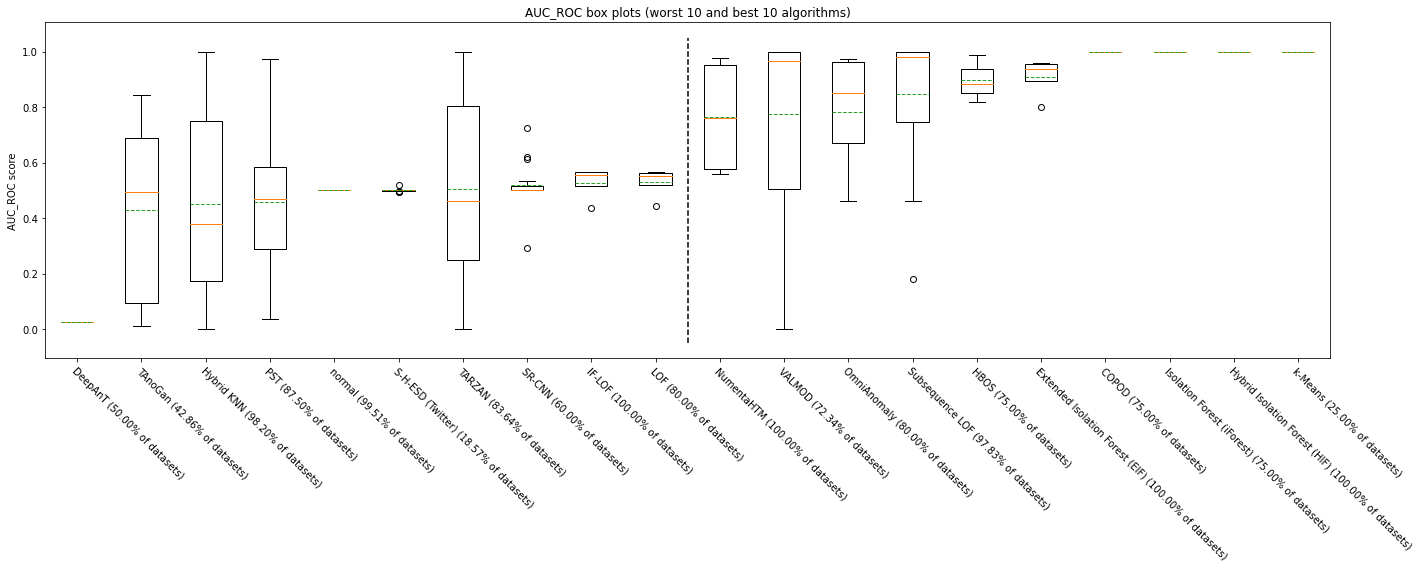

In [17]:
n_show = 20
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({dataset_count_lut[c]:6.2%} of datasets)"

fig = plot_boxplot(df_asl, title="AUC_ROC box plots", ax_label="AUC_ROC score", fmt_label=fmt_label, n_show=n_show)